In [1]:
#written by Francis Osei Tutu Afrifa, 2022.

from warnings import filterwarnings

filterwarnings('ignore')

from distributed import Client
client = Client(n_workers = 2, threads_per_worker=1, memory_limit='4GB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:53034/status,
Dashboard: http://127.0.0.1:53034/status,Workers: 2
Total threads: 2,Total memory: 7.45 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:53035,Workers: 2
Dashboard: http://127.0.0.1:53034/status,Total threads: 2
Started: Just now,Total memory: 7.45 GiB
Comm: tcp://127.0.0.1:53055,Total threads: 1
Dashboard: http://127.0.0.1:53056/status,Memory: 3.73 GiB
Nanny: tcp://127.0.0.1:53039,


First Let's import our packages:

In [2]:
%%time
from scipy import io
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

import os
cwd = os.getcwd()
### print the current working directory ###
cwd

CPU times: total: 1.67 s
Wall time: 1.97 s


'C:\\Users\\Francis\\Desktop\\LAB\\PhysMet\\assign_2'

<b/> Let's read the sounding data and a phycon file containing a dictionary of some common physical constants </b>

In [3]:
%%time
### Read the phycon dictionary file using scipy and assign it to the variable phycon_file
phycon_file = io.readsav('phycon.sav')

### Read the sounding data using pandas and assign it to the variable da_file
da_file = pd.read_csv('20220912_1655.csv', encoding= 'unicode_escape')

### Let's see what our sounding data contains:
da_file

CPU times: total: 15.6 ms
Wall time: 20.9 ms


,Time [sec],P [hPa],T [°C],Hu [%],Ws [m/s],Wd [°],Ws U [m/s],Ws V [m/s],Alt [m],Lon [°],Lat [°],Dew [°C]
0,0,787.0,21.6,22,0.0,0,0.0,0.0,2200,-105.581200,41.313200,9.6
1,1,786.4,21.2,21,0.1,3,0.0,-0.1,2207,-105.581183,41.313182,-1.7
2,2,785.8,20.9,21,0.1,3,0.0,-0.1,2214,-105.581167,41.313165,-2.5
3,3,785.2,20.5,20,0.2,3,0.0,-0.2,2221,-105.581150,41.313147,-3.2
4,4,784.5,20.1,19,0.3,3,0.0,-0.3,2227,-105.581133,41.313129,-4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6086,6086,534.8,-6.5,999999,5.6,341,1.8,-5.3,5390,-105.295032,40.994513,999999.0
6087,6087,535.7,-6.4,999999,5.7,340,1.9,-5.4,5378,-105.295006,40.994464,999999.0
6088,6088,536.5,-6.4,999999,5.7,339,2.0,-5.3,5366,-105.294981,40.994416,999999.0
6089,6089,537.3,-6.3,999999,5.7,339,2.1,-5.3,5354,-105.294955,40.994368,999999.0


In [4]:
phycon_file

{'tko': 273.15,
 'po': 100000.0,
 'r': 8.3144,
 'rd': 287.05,
 'rv': 461.51,
 'epsilon': 0.622,
 'cpd': 1005.2,
 'cpv': 1870.4,
 'cl': 4218.0,
 'ci': 2106.0,
 'lvo': 2500800.0,
 'lso': 2834500.0,
 'g': 9.81}

Before building our functions, let's exctract the constants we need from the phycon_file:

In [5]:
rd = phycon_file['rd']  ### Rd (specific gas constant for dry air) ###
g0 = phycon_file['g']   ### g (acceleration due to gravity) ###
tk0 = phycon_file['tko']  ### Tko (conversion between Kelvin and Celsius)

<b/> Let's define a function for the Isothermal model (Q.4) </b>

In [6]:
%%time
def hypso_isothermal(data):
    Z0 = data['Alt [m]'][0]; P0 = data['P [hPa]'][0]; T0 = data['T [°C]'][0]+ tk0; z_array = [Z0,]
    for i in range(0,len(data)-1):
        Pf = data['P [hPa]'][i+1]   ### Final Pressure
        const = (rd*T0)/g0
        Zf = Z0 + const * np.log(P0/Pf)
        z_array.append(Zf)
        
    return z_array

CPU times: total: 0 ns
Wall time: 0 ns


<b/> Let's define a function for the Explicit model (Q.5) </b>

In [7]:
%%time
### I actually managed to build this function with the help of Eden Koval's idea / guidance:
def hypso_explicit_init(data):
    z_array = [data['Alt [m]'][0],]
    for i in range(1,len(data)):
        P1 = data['P [hPa]'][i-1]; P2 = data['P [hPa]'][i]
        T1 = data['T [°C]'][i-1]+ tk0; T2 = data['T [°C]'][i] + tk0
        mn_temp = (T1+T2)/2
        mn_press = (P1+P2)/2
        press_diff = P1-P2
        Z2 = z_array[i-1] + ((rd/g0)*mn_temp*(1/mn_press)*press_diff)
        z_array.append(Z2)
        
    return z_array


### And then I came up with my own (which I used for the computation) based on the idea above:
def hypso_explicit(data):
    j = 0; z_array = [data['Alt [m]'][0],]
    for i in range(0,len(data)-1):
        Z1  = data['Alt [m]'][j]
        P1 = data['P [hPa]'][j]; T1 = data['T [°C]'][j] + tk0
        P2 = data['P [hPa]'][i+1]; T2 = data['T [°C]'][i+1] + tk0
        mn_temp = (T1+T2)/2  ### Mean temperature
        mn_press = (P1+P2)/2  ### Mean pressure
        press_diff = P1-P2    ### Pressure difference
        Z2 = Z1 + ((rd/g0)*mn_temp*(1/mn_press)*press_diff)  ### calculate Z2
        z_array.append(Z2)
        j +=1
    return z_array

CPU times: total: 0 ns
Wall time: 0 ns


<b/> Q.6 & 7.  Here's a plot of the measured pressure (in millibars) on the X-axis against calculated heights from the <span style="color:red">isothermal (solid red line)</span> and <span style="color:blue">explicit (dashed blue line)</span> models [in kilometers] on the Y-axis: </b>

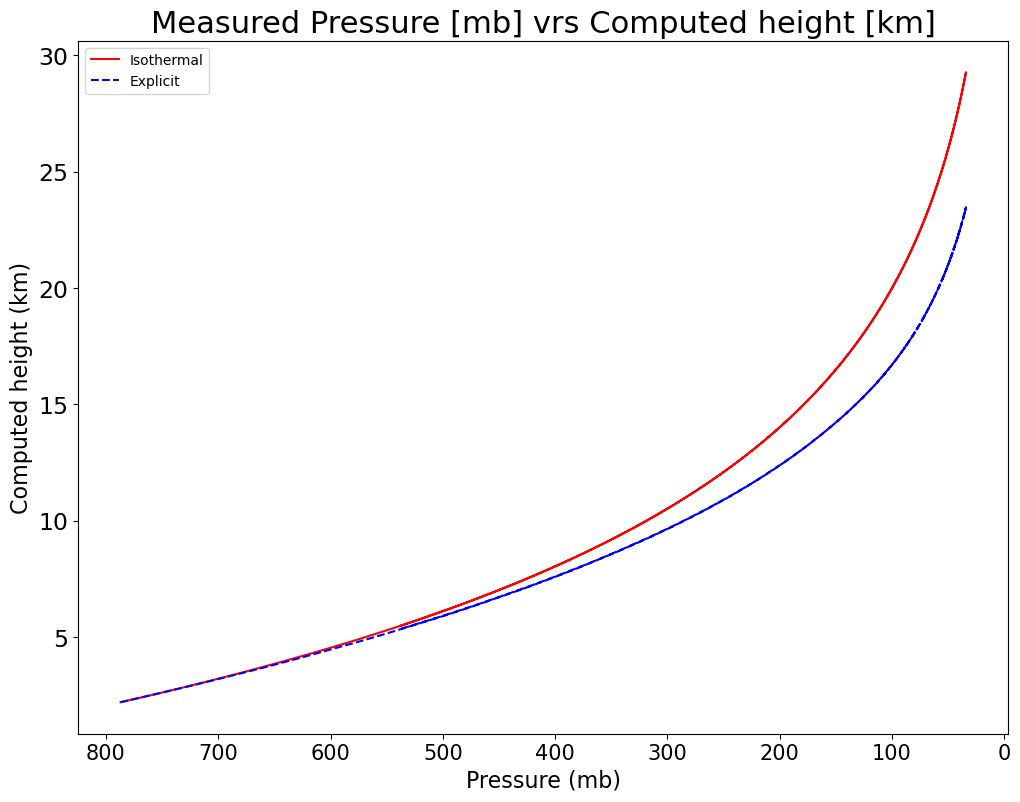

In [8]:
parameters = {'axes.labelsize': 16, 'xtick.labelsize':15, 'ytick.labelsize':17,'axes.titlesize': 22}
plt.rcParams.update(parameters)

Fig, axes = plt.subplots(figsize=(12,9)) ## 1200 pixels wide by 900 pixels high ##
axes.plot(da_file['P [hPa]'], np.array(hypso_isothermal(da_file))*10**-3, 'r', label = 'Isothermal')
axes.plot(da_file['P [hPa]'], np.array(hypso_explicit(da_file))*10**-3, '--b', label = 'Explicit')
axes.set(title = 'Measured Pressure [mb] vrs Computed height [km]', xlabel='Pressure (mb)', ylabel='Computed height (km)')
plt.gca().invert_xaxis()
axes.legend()
plt.savefig('./%s.png' %('afrifa_lab2_pre-Vr-hght'),dpi=100)
plt.show()

<b/> Q.8. Here's a plot of the computed heights from the <span style="color:red">isothermal (solid red line)</span> and <span style="color:blue">explicit (dashed blue line)</span> models [in kilometers] on the Y-axis as a function of actual (measured) height on the X-axis : </b>

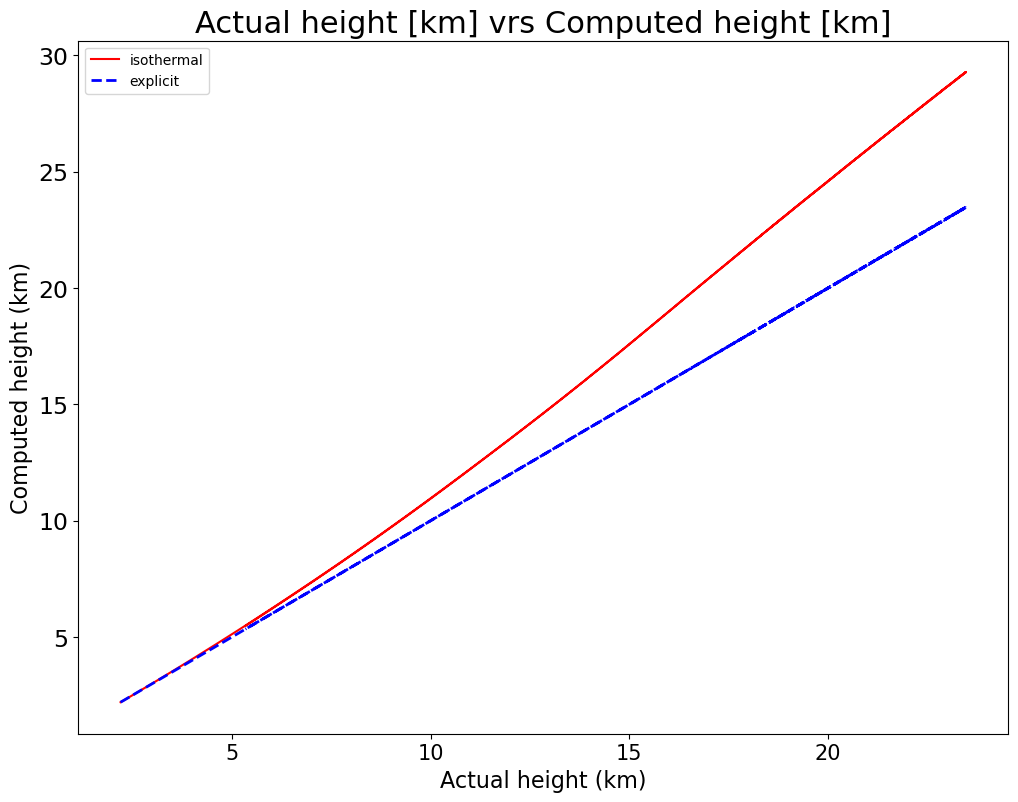

In [9]:
parameters = {'axes.labelsize': 16, 'xtick.labelsize':15, 'ytick.labelsize':17,'axes.titlesize': 22}
plt.rcParams.update(parameters)

Fig, axes = plt.subplots(figsize=(12,9)) ## 1200 pixels wide by 900 pixels high ##
axes.plot(da_file['Alt [m]']*10**-3, np.array(hypso_isothermal(da_file))*10**-3, 'r', label = 'isothermal')
axes.plot(da_file['Alt [m]']*10**-3, np.array(hypso_explicit(da_file))*10**-3, '--b', label = 'explicit', linewidth = 2)
axes.set(title = 'Actual height [km] vrs Computed height [km]', xlabel='Actual height (km)', ylabel='Computed height (km)')
plt.legend()
plt.savefig('./%s.png' %('afrifa_lab2_act_hgt-Vr-comp_hght'),dpi=100)
plt.show()

<b/> Q.9. Here's a plot that shows the difference between the computed heights (<span style="color:red">isothermal</span> & <span style="color:blue"> explicit </span>) and actual height (in meters, computed minus actual) on the Y-axis as a function of actual (measured) height on the X-axis : </b>

For easy computation, let's do this:


In [10]:
### First make a copy of the Pressure and altitude data (columns) from the sounding data ###
sounding_data = da_file[['P [hPa]', 'T [°C]', 'Alt [m]']].copy()

### Then we add the computed altitudes / heights from both the isothermal and explicit models to the dataframe:
sounding_data['Alt_Iso [m]'] = hypso_isothermal(sounding_data)
sounding_data['Alt_Expli [m]'] = hypso_explicit(sounding_data)

### Let's see our new table of data:
sounding_data

,P [hPa],T [°C],Alt [m],Alt_Iso [m],Alt_Expli [m]
0,787.0,21.6,2200,2200.000000,2200.000000
1,786.4,21.2,2207,2206.577858,2206.573394
2,785.8,20.9,2214,2213.160736,2213.570595
3,785.2,20.5,2221,2219.748643,2220.567791
4,784.5,20.1,2227,2227.440899,2228.658329
...,...,...,...,...,...
6086,534.8,-6.5,5390,5532.014369,5390.321899
6087,535.7,-6.4,5378,5517.512356,5376.878080
6088,536.5,-6.4,5366,5504.642117,5366.352381
6089,537.3,-6.3,5354,5491.791055,5354.367556


Finally we can go ahead and plot using:

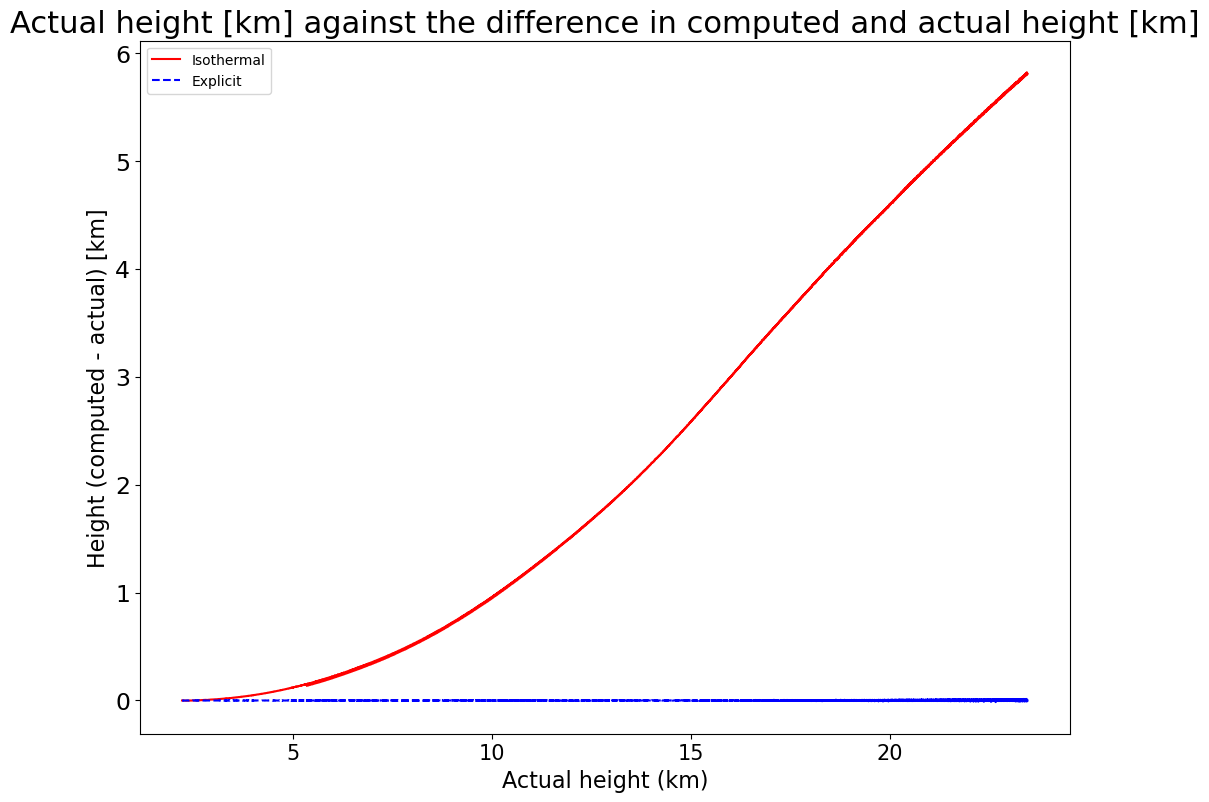

In [11]:
parameters = {'axes.labelsize': 16, 'xtick.labelsize':15, 'ytick.labelsize':17,'axes.titlesize': 22}
plt.rcParams.update(parameters)

Fig, axes = plt.subplots(figsize=(12,9)) ## 1200 pixels wide by 900 pixels high ##
axes.plot(sounding_data['Alt [m]']*10**-3, (sounding_data['Alt_Iso [m]']*10**-3 )-(sounding_data['Alt [m]']*10**-3), 'r', label='Isothermal')
axes.plot(sounding_data['Alt [m]']*10**-3, (sounding_data['Alt_Expli [m]']*10**-3)-(sounding_data['Alt [m]']*10**-3), '--b', label='Explicit')
axes.set(title = 'Actual height [km] against the difference in computed and actual height [km]',
         xlabel='Actual height (km)', ylabel='Height (computed - actual) [km]')
plt.legend()
plt.savefig('./%s.png' %('afrifa_lab2_act_height-Vr-diff_comp_height'),dpi=100)
plt.show()

***
<h2> Answers to Questions </h2>

***

1. Comparing the two models, at the top of the sounding (lowest pressure), which has the greatest calculated height? 


> `Ans: The Isothermal model has the greatest calculated height at the top of the sounding.` 



2. Consider the assumptions used in the two models and the actual temperature as a function of altitude, explain the difference in calculated height between the two models. Why does temperature matter? 

> <span style= "color: green">  Let's First visualize a plot of the actual temperature as a function of altitude for both models:</span>

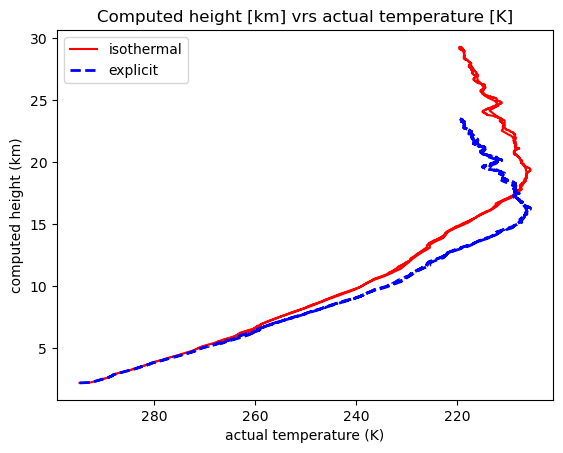

In [14]:
plt.plot(da_file['T [°C]']+ tk0, np.array(hypso_isothermal(da_file))*10**-3, 'r', label = 'isothermal')
plt.plot(da_file['T [°C]']+ tk0, np.array(hypso_explicit(da_file))*10**-3, '--b', label = 'explicit', linewidth = 2)
plt.xlabel('actual temperature (K)')
plt.ylabel('computed height (km)')
plt.gca().invert_xaxis()
plt.legend()
plt.title('Computed height [km] vrs actual temperature [K]')
plt.show()

>`Ans: It is well known from literature that temperature decreases with increasing altitude in the lower atmosphere (precisely the troposphere). From the figure above, for the explicit model, because the temperature was varying at each level (average temperatures), there was an increase in height. However, for the isothermal model, because the temperature was constant at all levels, the height kept on increasing as well (this time, higher increase compared to the explicit model).   Temperature matters because of the two different assumptions made on temperature for the two models. The difference in height between the two models is due to temperature differences. `


3. Does the difference between the two models increase, decrease, or stay about the same as altitude increases? Why? 

> `Ans: The difference between the two models increases. This is because temperature decreases with altitude in the lower atmosphere. The temperature for the isothermal model was kept constant and the temperature for the explicit model varied with respect to each height.` 


4. Examining the plots comparing computed and actual height, how do you think the sounding retrieval program calculates height in this case? 

> `Ans: Comparing the computed height values for both models, the sounding retrieval program calculates height using the explicit model, because its altitude values are closer to the actual height values recorded.` 